In [52]:
%load_ext autoreload
%autoreload

import io
import os
import sys
import django
import glob
import json
import re
import requests
from IPython.core.debugger import set_trace
from pathlib import Path
from django.core.files.base import ContentFile
from rest_framework import serializers
from tqdm.notebook import tqdm
from google.cloud import vision
from google.cloud import storage
from PIL import Image, ImageSequence
from gensim.models import Doc2Vec
from IPython.core.debugger import set_trace
import IPython
import collections

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parentdir)
django.setup()

import getch.models as m
from django.db.models import Q
from django.apps import apps
from django_currentuser.middleware import get_current_user

model_path = 'doc2vec.model'
d2v = Doc2Vec.load(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# django를 불러오면 아래를 굳이 부를필요 없는듯
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath(os.path.join(os.getcwd(), 'sideb-proejct-0e33d8c0b0a9.json'))

In [3]:
def detect_labels(localpath=None, url=None):
    client = vision.ImageAnnotatorClient()

    if localpath:
        with io.open(localpath, 'rb') as image_file:
            content = image_file.read() 

        image = vision.Image(content=content)

    else:
        image = vision.Image()
        image.source.image_uri = url
        
        # 장고 이미지필드의 경우, 아래처럼도 가능
        # image = vision.Image(content=_post.pix.read())
    
    response = client.label_detection(image=image)
    labels = response.label_annotations
    labels = [label.description.lower().replace(' ', '_') for label in labels]
    
    return ', '.join(labels)

In [4]:
# _post = m.Post.objects.select_subclasses()[0]; _post
# _post = m.PostVoteAB.objects.filter(pixlabel_a='장희령 스탈'); _post
_post = m.PostVoteAB.objects.filter(pixlabel_a='Gyakusou')[0]; _post

<PostVoteAB: AB | 2020-12-31 14:41:10.074659+00:00 | 미스터변 | magrittelim@gmail.com>

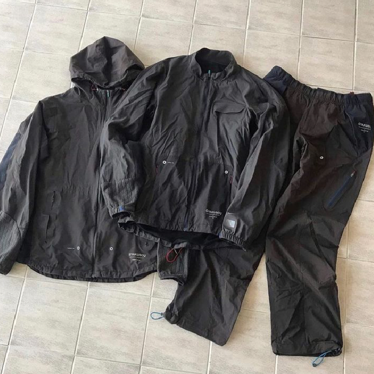

In [5]:
# path = '신발신발.png'
path = _post.pix_a
img = Image.open(path)
img.resize((int(img.width / 2), int(img.height / 2)))

In [6]:
detect_labels(url=_post.pix_a.url)

'black'

# population

In [7]:
for p in tqdm(m.Post.objects.select_subclasses()):
    if p.type == 'postvoteox':
        tokens = detect_labels(url=p.pix.url)
        m.Postpix.objects.create(key='ox', post=p, img=p.pix, tokens=tokens)
        
    elif p.type == 'postvoteab':
        tokens_a = detect_labels(url=p.pix_a.url)
        tokens_b = detect_labels(url=p.pix_b.url)
        m.Postpix.objects.create(key='a', post=p, img=p.pix_a, tokens=tokens_a, desc=p.pixlabel_a)
        m.Postpix.objects.create(key='b', post=p, img=p.pix_b, tokens=tokens_b, desc=p.pixlabel_b)

  0%|          | 0/112 [00:00<?, ?it/s]

# testify

In [38]:
def preproc(text, remove_url=True, remove_mention=False, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()

In [49]:
boo_id = 60
boo = m.Boo.objects.get(id=boo_id)
styletags = list(boo.styletags.values_list('tag', flat=True))
fashiontems = list(boo.fashiontems.values_list('item', flat=True))
baseid = preproc(boo.nick.lower() + ' ' + boo.text.lower()).split(' ') + styletags + fashiontems

print(styletags)
print(fashiontems)
print(baseid)

['어깡', '역삼각형', '대두', '상비', '오버핏럽']
['팬츠', '아우터']
['미스터변', '옷잘입는남자', '어깡', '역삼각형', '대두', '상비', '오버핏럽', '팬츠', '아우터']


In [11]:
votes = m.Boo.objects.get(id=boo_id).voting_record

In [12]:
# pos = []
# neg = []

# for p in m.Post.objects.filter(pk__in=votes).prefetch_related('postpix_set').select_subclasses():
#     if p.type == 'postvoteab':
#         if votes[p.id] == 0:
#             pos += p.postpix_set.get(key='a').tokens.split(', ')
#             neg += p.postpix_set.get(key='b').tokens.split(', ')
            
#         else:
#             neg += p.postpix_set.get(key='a').tokens.split(', ')
#             pos += p.postpix_set.get(key='b').tokens.split(', ')

In [97]:
pos = []
neg = []

for pix in tqdm(m.Postpix.objects.filter(post_id__in=votes).select_related('post')):
    act = votes[pix.post.id]
    desc = preproc(pix.desc.lower()).split(' ') if pix.desc else []
    
    if pix.key=='ox' and act==0:
        pos += pix.tokens.split(', ') + desc
    
    elif pix.key=='ox' and act==1:
        neg += pix.tokens.split(', ') + desc
        
    elif (pix.key=='a' and act==0) or (pix.key=='b' and act==1):
        pos += pix.tokens.split(', ') + desc
        
    elif (pix.key=='a' and act==1) or (pix.key=='b' and act==0):
        neg += pix.tokens.split(', ') + desc

  0%|          | 0/158 [00:00<?, ?it/s]

In [98]:
len(pos), len(neg)

(826, 808)

In [107]:
list(dict((collections.Counter(pos) - collections.Counter(neg)).most_common(10)).keys())

['footwear',
 'style',
 'athletic_shoe',
 'sneakers',
 'jacket',
 'outerwear',
 'wool',
 'clothing',
 'shoe',
 'bag']

In [108]:
list(dict((collections.Counter(neg) - collections.Counter(pos)).most_common(10)).keys())

['white',
 'black',
 'collar',
 'standing',
 'fur_clothing',
 'active_shirt',
 'pattern',
 'formal_wear',
 'uniform',
 'clothes_hanger']

In [104]:
qry_pos = d2v.infer_vector(pos, epochs=500)
qry_neg = d2v.infer_vector(neg, epochs=500)
qry_baseid = d2v.infer_vector(baseid, epochs=500)
d2v.docvecs.most_similar(positive=[qry_pos, qry_baseid], negative=[qry_neg], topn=10)

[('eider', 0.42397236824035645),
 ('barrel', 0.40111589431762695),
 ('haveagoodtime', 0.37154486775398254),
 ('barbour', 0.3517550826072693),
 ('fillingpieces', 0.3487234115600586),
 ('giordano', 0.34721603989601135),
 ('billylosangeles', 0.3421420454978943),
 ('mizuno', 0.33944040536880493),
 ('birkenstock', 0.33681154251098633),
 ('critic', 0.3367672562599182)]

In [63]:
qry_pos = d2v.infer_vector(pos, epochs=500)
qry_neg = d2v.infer_vector(neg, epochs=500)
qry_baseid = d2v.infer_vector(baseid, epochs=500)
d2v.wv.most_similar(positive=[qry_pos, qry_baseid], negative=[qry_neg], topn=10)

[('듣자', 0.4584624767303467),
 ('별보러', 0.43226414918899536),
 ('우비', 0.42545634508132935),
 ('아리랑', 0.41935038566589355),
 ('꽃길', 0.41245749592781067),
 ('어여쁘고', 0.4106650948524475),
 ('광고인지', 0.41063159704208374),
 ('으아아', 0.4104529023170471),
 ('박보검뮤직비디오', 0.4103260040283203),
 ('사람', 0.4098772406578064)]

In [28]:
d2v.wv.vocab['기본']

In [6]:
qry_vec = d2v.infer_vector(labels, epochs=500)
d2v.docvecs.most_similar(positive=[qry_vec], topn=10)

[('acronym', 0.8029796481132507),
 ('acoldwall', 0.7641227841377258),
 ('gyakusou', 0.7501798868179321),
 ('y3', 0.7264542579650879),
 ('visvim', 0.7249417304992676),
 ('1017alyx9sm', 0.7163081169128418),
 ('undefeated', 0.7145105600357056),
 ('offwhite', 0.7137323617935181),
 ('onitsukatiger', 0.7095181345939636),
 ('undercover', 0.7080243825912476)]

In [130]:
qry_vec = d2v.infer_vector(labels, epochs=500)
d2v.wv.most_similar(positive=[qry_vec], topn=10)

[('에어조던5', 0.8540251851081848),
 ('토로', 0.8507999181747437),
 ('가능하시구요', 0.8153282403945923),
 ('나이키매니아', 0.8092210292816162),
 ('클릿슈즈', 0.8091098666191101),
 ('멕시코66', 0.8079787492752075),
 ('르브론x', 0.8074090480804443),
 ('모어업템포', 0.8069274425506592),
 ('풋락커', 0.8063082695007324),
 ('폼포짓', 0.8038229942321777)]

In [121]:
qry_vec = d2v.infer_vector(['어깡'], epochs=500)
d2v.docvecs.most_similar(positive=[qry_vec], topn=10)

[('gucci', 0.07552319765090942),
 ('louisvuitton', 0.06907099485397339),
 ('kenzo', 0.06679679453372955),
 ('prada', 0.06515025347471237),
 ('bally', 0.06012149155139923),
 ('fendi', 0.04744155704975128),
 ('gentlemonster', 0.0444667786359787),
 ('eider', 0.04029855877161026),
 ('tomford', 0.03858783841133118),
 ('paulsmith', 0.03504317253828049)]

In [30]:
qry_vec = d2v.infer_vector([boo.nick], epochs=500)
d2v.wv.most_similar(positive=[qry_vec], topn=10)

[('송일국', 0.30594557523727417),
 ('승부사', 0.2758767008781433),
 ('신서유기', 0.27055495977401733),
 ('팔아야귀국', 0.2643117904663086),
 ('기리', 0.25868964195251465),
 ('아들', 0.24789908528327942),
 ('민낯', 0.24750250577926636),
 ('중국', 0.24671602249145508),
 ('무시하는', 0.24649766087532043),
 ('수거', 0.24602524936199188)]